In [ ]:
# https://youtu.be/bIaT2X5Hd5k



"""
Image colorization using Autoencoders. Transfer learning using VGG.
"""

Bu çalışmada VGG modelinin ilk 18 eğitilmiş katmanını kullanarak (feature extranction layers) buna katmanlar ekleyip resim renklendirme işlemi yapacağız.

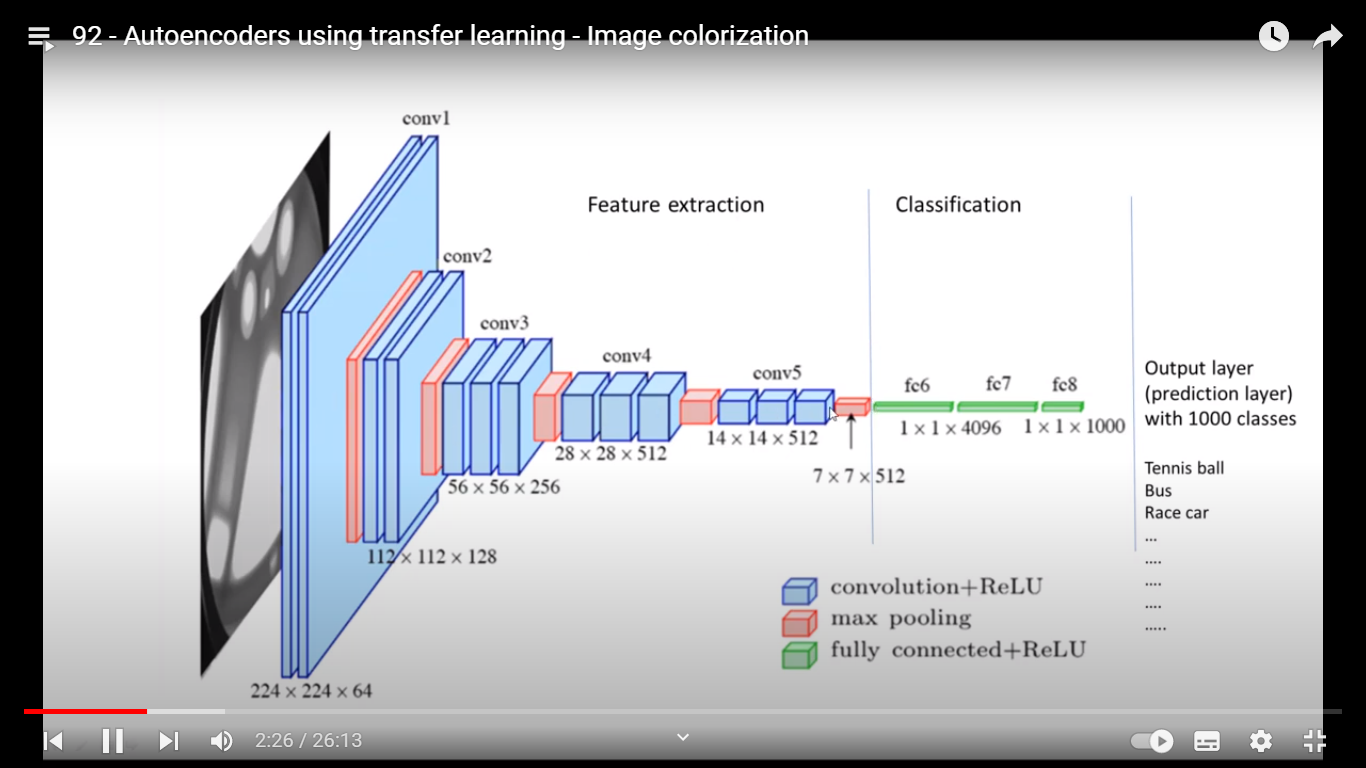

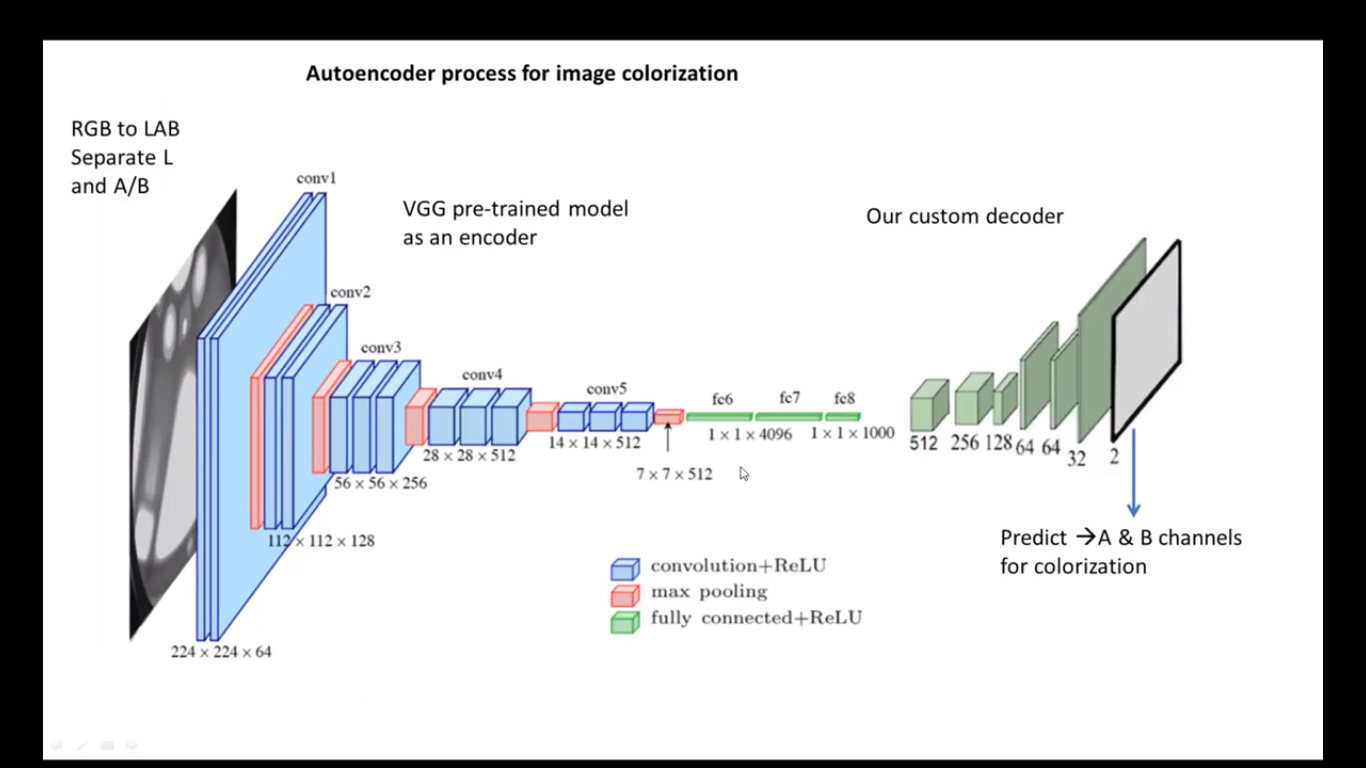

Bu resimlerden ilki orjinal VGG katmanları göstermektedir. Ok ile gösterilen katmana kadar olan ilk 18 katman alınacak ikinci resimde gösterildiği gibi kendi katmanlarımız eklenecektir.

In [2]:
"""
Because we are going to replace the encoder part with VGG16, 
we don’t need it as a classifier, we need it as a feature extractor so, 
the last dense layers isn’t needed we have to pop them up.
here, we iterate on each layer except the last dense layers so, 
we add 19 layer to our model. the dimension of last layer volume is “7x7x512”. 
we will be using that latent space volume as a feature vector to be input to the decoder.
 and the decoder is going to learn the mapping from the latent space vector to ab channels. 
 we want the layers of VGG16 with its original weights without changing them, 
 so that we set the trainable parameter in each layer to false because we don’t want to train them again.
"""

'\nBecause we are going to replace the encoder part with VGG16, \nwe don’t need it as a classifier, we need it as a feature extractor so, \nthe last dense layers isn’t needed we have to pop them up.\nhere, we iterate on each layer except the last dense layers so, \nwe add 19 layer to our model. the dimension of last layer volume is “7x7x512”. \nwe will be using that latent space volume as a feature vector to be input to the decoder.\n and the decoder is going to learn the mapping from the latent space vector to ab channels. \n we want the layers of VGG16 with its original weights without changing them, \n so that we set the trainable parameter in each layer to false because we don’t want to train them again.\n'

In [3]:
from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
import keras
import os

from keras.applications.vgg16 import VGG16
vggmodel = VGG16()

#num = 0

553476096/553467096 [==============================] - 4s 0us/step


In [4]:
#yeni bir model oluşturduk ve ilk 18 katmanı vgg modelden kopyaladık
newmodel = Sequential() 

for i, layer in enumerate(vggmodel.layers):
    if i<19:          #Only up to 19th layer to include feature extraction only
      newmodel.add(layer)
newmodel.summary()
for layer in newmodel.layers:
  layer.trainable=False   #We don't want to train these layers again, so False.

#burada False diyerek eğitilmiş veriyi değiştirmeden mevcut ağırlıkları ile kullanmış oluyoruz 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [5]:
"""
VGG16 is expecting an image of 3 dimension with size 224x224 as an input, 
in preprocessing we have to scale all images to 224 instead of 256
"""

path = 'drive/MyDrive/data/resimler'
#Normalize images - divide by 255
train_datagen = ImageDataGenerator(rescale=1. / 255)

train = train_datagen.flow_from_directory(path, target_size=(224, 224), batch_size=32, class_mode=None)

Found 355 images belonging to 1 classes.


In [6]:
#Convert from RGB to Lab
"""
by iterating on each image, we convert the RGB to Lab. 
Think of LAB image as a grey image in L channel and all color info stored in A and B channels. 
The input to the network will be the L channel, so we assign L channel to X vector. 
And assign A and B to Y.
"""

X =[]
Y =[]
for img in train[0]:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0]) 
      Y.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
      #so we divide the values by 128 to restrict values to between -1 and 1.
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y
print(X.shape)
print(Y.shape)

(32, 224, 224, 1)
(32, 224, 224, 2)


In [7]:
#now we have one channel of L in each layer but, VGG16 is expecting 3 dimension, 
#so we repeated the L channel two times to get 3 dimensions of the same L channel
#VGG RGB formatında giriş beklediğinden gri resmi ifade eden L kanlını RGB ye çeviriyoruz. newmodel'e gönderip çıktısını 
#elde ediyoruz. Gerekli dönüşümler yapılıp sonraki katmanlara uygun hale getiriliyor
vggfeatures = []
for i, sample in enumerate(X):
  sample = gray2rgb(sample)
  sample = sample.reshape((1,224,224,3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((7,7,512))
  vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)


(32, 7, 7, 512)


In [8]:

# Gri resme renk tahmini yapacak ek katmlarımızı oluşturuyoruz.
#Decoder
model = Sequential()

model.add(Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(7,7,512)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 up_sampling2d_1 (UpSampling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)       

In [16]:
model.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])
model.fit(vggfeatures, Y, verbose=1, epochs=100, batch_size=128)
#burada epoch binlerce yapılıyor
model.save('colorize_autoencoder_VGG16.model')

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.0346 - accuracy: 0.6043
Epoch 2/100
1/1 [==============================] - 1s 973ms/step - loss: 0.3546 - accuracy: 0.4921
Epoch 3/100
1/1 [==============================] - 1s 955ms/step - loss: 0.0828 - accuracy: 0.5078
Epoch 4/100
1/1 [==============================] - 1s 986ms/step - loss: 0.0245 - accuracy: 0.5119
Epoch 5/100
1/1 [==============================] - 1s 970ms/step - loss: 0.0164 - accuracy: 0.5228
Epoch 6/100
1/1 [==============================] - 1s 970ms/step - loss: 0.0165 - accuracy: 0.5131
Epoch 7/100
1/1 [==============================] - 1s 967ms/step - loss: 0.0165 - accuracy: 0.5154
Epoch 8/100
1/1 [==============================] - 1s 952ms/step - loss: 0.0161 - accuracy: 0.5216
Epoch 9/100
1/1 [==============================] - 1s 953ms/step - loss: 0.0157 - accuracy: 0.5221
Epoch 10/100
1/1 [==============================] - 1s 943ms/step - loss: 0.0155 - accuracy: 0.5269
Epoch 11/100

In [14]:
!mkdir -p images/colorization2/vgg_result/

In [17]:
############################################
#Predicting using saved model.
model = tf.keras.models.load_model('colorize_autoencoder_VGG16.model',
                                   custom_objects=None,
                                   compile=True)
testpath = 'drive/MyDrive/data/test_res/'
files = os.listdir(testpath)
for idx, file in enumerate(files):
    test = img_to_array(load_img(testpath+file))
    test = resize(test, (224,224), anti_aliasing=True)
    test*= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))
    #print(L.shape)
    vggpred = newmodel.predict(L)
    ab = model.predict(vggpred)
    #print(ab.shape)
    ab = ab*128
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab
    imsave('images/colorization2/vgg_result/result'+str(idx)+".jpg", lab2rgb(cur))